# Building a convolutional neural network

## Setup

In [1]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [86]:
words = open("names.txt").read().splitlines()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# Build vocabulary and mappings
chars = sorted(list(set("".join(words))))
s_to_i = {s: i + 1 for i, s in enumerate(chars)}
s_to_i["."] = 0

i_to_s = {i: s for s, i in s_to_i.items()}

vocab_size = len(s_to_i)

In [4]:
CONTEXT_LENGTH = 3  # Block size: number of previous characters to consider when predicting the next character


def build_dataset(words, label):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * CONTEXT_LENGTH

        for char in word + ".":
            ix = s_to_i[char]
            X.append(context)
            Y.append(ix)

            # print("".join([i_to_s[i] for i in context]), "--->", i_to_s[ix])
            context = context[1:] + [ix]

        # print("=" * 10)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(label, X.shape, Y.shape)
    return X, Y

In [5]:
random.seed(42)

# Shuffle the words in the dataset
random.shuffle(words)

# Split the dataset into train, validation and test sets
train_index = int(0.8 * len(words))
val_index = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:train_index], "train")
X_val, Y_val = build_dataset(words[train_index:val_index], "validation")
X_test, Y_test = build_dataset(words[val_index:], "test")

train torch.Size([182625, 3]) torch.Size([182625])
validation torch.Size([22655, 3]) torch.Size([22655])
test torch.Size([22866, 3]) torch.Size([22866])


In [7]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print("".join([i_to_s[i.item()] for i in x]), "--->", i_to_s[y.item()])

... ---> y
..y ---> u
.yu ---> h
yuh ---> e
uhe ---> n
hen ---> g
eng ---> .
... ---> d
..d ---> i
.di ---> o
dio ---> n
ion ---> d
ond ---> r
ndr ---> e
dre ---> .
... ---> x
..x ---> a
.xa ---> v
xav ---> i
avi ---> e


In [8]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(size=(fan_in, fan_out)) * (1 / fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdims=True)
            xvar = x.var(dim=0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # Standardize the input layer
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Scale and shift the output layer
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean

                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [9]:
torch.manual_seed(42)

In [10]:
n_embed = 10
n_hidden = 200

C = torch.randn(size=(vocab_size, n_embed))

layers = [
    Linear(n_embed * CONTEXT_LENGTH, n_hidden, bias=False),
    BatchNorm1d(n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 12097


In [11]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    # Forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, Yb)

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.2966
10000/100000 | Loss: 2.2322
20000/100000 | Loss: 2.4111
30000/100000 | Loss: 2.1004
40000/100000 | Loss: 2.3157
50000/100000 | Loss: 2.2104
60000/100000 | Loss: 1.8379
70000/100000 | Loss: 1.9243
80000/100000 | Loss: 2.6651
90000/100000 | Loss: 2.0460


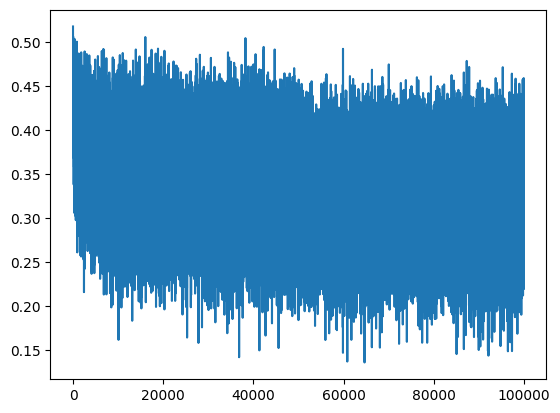

In [25]:
plt.plot(losses)

In [12]:
for layer in layers:
    layer.training = False


# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    emb = C[x]

    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)

    loss = F.cross_entropy(x, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0865
validation loss: 2.1239


In [24]:
starting_string = "..."

for _ in range(20):
    out = []
    context = [s_to_i[s] for s in starting_string]
    while True:
        emb = C[torch.tensor([context])]
        x = emb.view(emb.shape[0], -1)
        for layer in layers:
            x = layer(x)

        logits = x
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print((starting_string + "".join([i_to_s[i] for i in out])).replace(".", ""))

eveond
molis
janeevangeraider
gahiel
adi
elin
kemiell
mich
gletta
amie
ivil
dason
ulah
luclyn


shrelakiyah
adelleen
mie
elynn
karletta
quentley


## Improving the model

### Learning rate plot

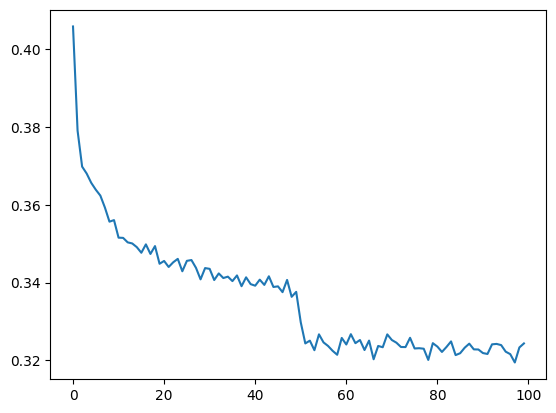

In [41]:
losses_collapsed = torch.tensor(losses).view(-1, 1000).mean(dim=1)
plt.plot(losses_collapsed)

### Forward pass

In [69]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(size=(fan_in, fan_out)) * (1 / fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdims=True)
            xvar = x.var(dim=0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # Standardize the input layer
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Scale and shift the output layer
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean

                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    # C = torch.randn(size=(vocab_size, n_embed))
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(size=(num_embeddings, embedding_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]


class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [70]:
n_embed = 10
n_hidden = 200

model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        Flatten(),
        Linear(n_embed * CONTEXT_LENGTH, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

parameters = model.parameters()

with torch.no_grad():
    model.layers[-1].weight *= 0.1

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 12097


In [73]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.2498
10000/100000 | Loss: 2.3841
20000/100000 | Loss: 2.3820
30000/100000 | Loss: 2.2400
40000/100000 | Loss: 2.0187
50000/100000 | Loss: 1.8417
60000/100000 | Loss: 2.3029
70000/100000 | Loss: 2.1766
80000/100000 | Loss: 2.1097
90000/100000 | Loss: 2.2862


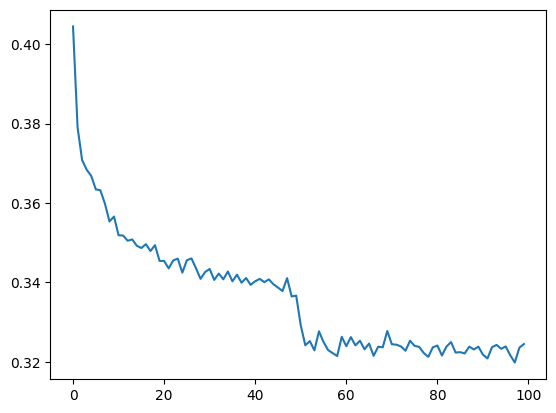

In [74]:
losses_collapsed = torch.tensor(losses).view(-1, 1000).mean(dim=1)
plt.plot(losses_collapsed)

### Calculating the loss

In [75]:
for layer in model.layers:
    layer.training = False

# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0877
validation loss: 2.1231


### Predicting from the model

In [76]:
starting_string = "..."

for _ in range(20):
    out = []
    context = [s_to_i[s] for s in starting_string]
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print((starting_string + "".join([i_to_s[i] for i in out])).replace(".", ""))

ayah
lia
marrilyne
dria
lambraskiel
jaifa
nix
hezariah
messeksier
pake
carlihana
sawella
basamoli
fincaison
simaevenn
blaykella
jeanny
amadodiel
iara
leico


# Hierarchical network

Now we attempt to build a network that progressively flattens the input, instead of smashing it together at the first layer.

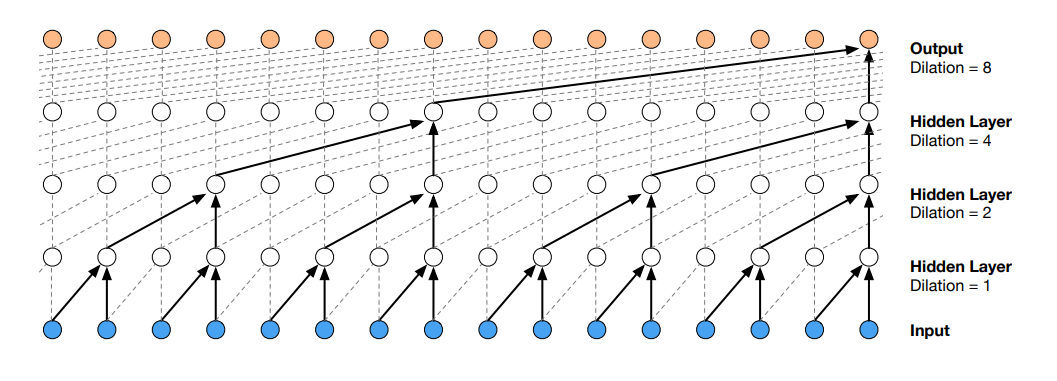

The above image is taken from the [WaveNet](https://arxiv.org/pdf/1609.03499.pdf) paper.

In [88]:
CONTEXT_LENGTH = 8  # Block size: number of previous characters to consider when predicting the next character

def build_dataset(words, label):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * CONTEXT_LENGTH

        for char in word + ".":
            ix = s_to_i[char]
            X.append(context)
            Y.append(ix)

            # print("".join([i_to_s[i] for i in context]), "--->", i_to_s[ix])
            context = context[1:] + [ix]

        # print("=" * 10)

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(label, X.shape, Y.shape)
    return X, Y

In [87]:
random.seed(42)

# Shuffle the words in the dataset
random.shuffle(words)

# Split the dataset into train, validation and test sets
train_index = int(0.8 * len(words))
val_index = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:train_index], "train")
X_val, Y_val = build_dataset(words[train_index:val_index], "validation")
X_test, Y_test = build_dataset(words[val_index:], "test")

train torch.Size([182625, 8]) torch.Size([182625])
validation torch.Size([22655, 8]) torch.Size([22655])
test torch.Size([22866, 8]) torch.Size([22866])


In [89]:
for x, y in zip(X_train[:20], Y_train[:20]):
    print("".join([i_to_s[i.item()] for i in x]), "--->", i_to_s[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [220]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(size=(fan_in, fan_out)) * (1 / fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            if x.ndim == 2:
                dims_to_reduce = 0
            elif x.ndim == 3:
                dims_to_reduce = (0, 1)

            xmean = x.mean(dim=dims_to_reduce, keepdims=True)
            xvar = x.var(dim=dims_to_reduce, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # Standardize the input layer
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Scale and shift the output layer
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean

                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    # C = torch.randn(size=(vocab_size, n_embed))
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(size=(num_embeddings, embedding_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    def __init__(self, n):
        # n = number of characters to consider as consecutive
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        # Changing the flattening logic to output a tensor with bigrams
        x = x.view(B, T // self.n, C * self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)

        self.out = x

        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [221]:
n_embed = 10
n_hidden = 68  # Arbitarily chosen to keep the same number of parameters as the previous model to compare if the consecutive flattening improves performance by efficiently utilizing the context information

model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(2),
        Linear(n_embed * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

parameters = model.parameters()

with torch.no_grad():
    model.layers[-1].weight *= 0.1

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 22397


In [213]:
batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(4,))
Xb, Yb = X_train[batch_ix], Y_train[batch_ix]
logits = model(Xb)

Xb

tensor([[ 0,  0,  0,  0,  0,  0,  0,  7],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 10,  5, 19],
        [ 0,  0,  0,  7,  9, 12,  1,  8]])

In [214]:
for layer in model.layers:
    print(layer.__class__.__name__, tuple(layer.out.shape))

Embedding (4, 8, 10)
FlattenConsecutive (4, 4, 20)
Linear (4, 4, 68)
BatchNorm1d (4, 4, 68)
Tanh (4, 4, 68)
FlattenConsecutive (4, 2, 136)
Linear (4, 2, 68)
BatchNorm1d (4, 2, 68)
Tanh (4, 2, 68)
FlattenConsecutive (4, 136)
Linear (4, 68)
BatchNorm1d (4, 68)
Tanh (4, 68)
Linear (4, 27)


In [222]:
epochs = 100000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 50000 else 1e-2
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/100000 | Loss: 3.3056
10000/100000 | Loss: 2.1827
20000/100000 | Loss: 1.7817
30000/100000 | Loss: 2.1080
40000/100000 | Loss: 1.9194


KeyboardInterrupt: 

In [223]:
losses_collapsed = torch.tensor(losses).view(-1, 1000).mean(dim=1)
plt.plot(losses_collapsed)

RuntimeError: shape '[-1, 1000]' is invalid for input of size 43949

In [224]:
for layer in model.layers:
    layer.training = False

# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 2.0513
validation loss: 2.1077


In [225]:
starting_string = "." * CONTEXT_LENGTH

for _ in range(20):
    out = []
    context = [s_to_i[s] for s in starting_string]
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print((starting_string + "".join([i_to_s[i] for i in out])).replace(".", ""))

ashani
halisa
lyyar
joniar
tarote
cozabel
soly
abi
adjoa
ewinhi
madhah
macem
rayleigh
alisha
bolkee
boruli
maluel
mari
frandod
macly


## Scaling up the network

In [226]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(size=(fan_in, fan_out)) * (1 / fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # Parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Forward pass
        if self.training:
            xmean = x.mean(dim=0, keepdims=True)
            xvar = x.var(dim=0, keepdims=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        # Standardize the input layer
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)

        # Scale and shift the output layer
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean

                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    # C = torch.randn(size=(vocab_size, n_embed))
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn(size=(num_embeddings, embedding_dim))

    def __call__(self, ix):
        self.out = self.weight[ix]
        return self.out

    def parameters(self):
        return [self.weight]


class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [227]:
n_embed = 24
n_hidden = 128

model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(2),
        Linear(n_embed * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

parameters = model.parameters()

with torch.no_grad():
    model.layers[-1].weight *= 0.1

print(f"Number of parameters: {sum(p.nelement() for p in parameters)}")

for p in parameters:
    p.requires_grad = True

Number of parameters: 76579


In [228]:
epochs = 50000
batch_size = 32
losses = []

for epoch in range(epochs):
    # Construct a minibatch
    batch_ix = torch.randint(low=0, high=X_train.shape[0], size=(batch_size,))
    Xb, Yb = X_train[batch_ix], Y_train[batch_ix]

    logits = model(Xb)

    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None

    loss.backward()

    # Update the parameters
    learning_rate = 1e-1 if epoch < 25000 else 1e-2
    for p in parameters:
        p.data += -learning_rate * p.grad

    # track stats
    if epoch % 10000 == 0:
        print(f"{epoch}/{epochs} | Loss: {loss.item():.4f}")

    losses.append(loss.log10().item())

0/50000 | Loss: 3.2889
10000/50000 | Loss: 2.2288
20000/50000 | Loss: 1.8474
30000/50000 | Loss: 2.0551
40000/50000 | Loss: 1.5939


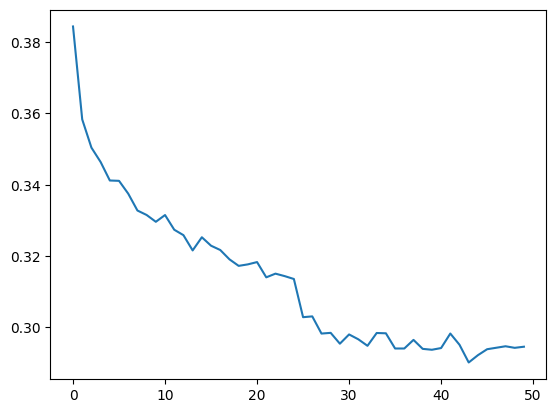

In [232]:
losses_collapsed = torch.tensor(losses).view(-1, 1000).mean(dim=1)
plt.plot(losses_collapsed)

In [233]:
for layer in model.layers:
    layer.training = False

# Calculate the loss
@torch.no_grad()
def calc_loss(split):
    x, y = {
        "train": (X_train, Y_train),
        "validation": (X_val, Y_val),
        "test": (X_test, Y_test),
    }[split]

    logits = model(x)

    loss = F.cross_entropy(logits, y)

    print(f"{split} loss: {loss.item():.4f}")


calc_loss("train")
calc_loss("validation")

train loss: 1.9461
validation loss: 2.0213


In [237]:
starting_string = "." * CONTEXT_LENGTH

for _ in range(20):
    out = []
    context = [s_to_i[s] for s in starting_string]
    while True:
        logits = model(torch.tensor([context]))

        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1).item()

        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print((starting_string + "".join([i_to_s[i] for i in out])).replace(".", ""))

kenesse
analay
some
sufa
denisia
liva
joshel
thalin
amaram
jamiah
rontai
miki
sindi
dravyn
eandreo
zyvino
khiritt
zim
jahleis
naverion
